## Shaking Earth: LANL Earthquake Prediction Challenge

https://www.kaggle.com/c/LANL-Earthquake-Prediction

In LANL Earthquake Prediction Challenge we try to predict time left to the next laboratory earthquake based on seismic signal data. Training data is one huge signal of length more than 629,100,000 (~150,000 x 4194), with 16 earthquakes. In test data we have 2624 separate chunks of length 150,000, for each of which we need to predict time to failure. Test result performance measure is MAE (mean absolute error).

We are going to build and cross-validate FF, XGB, RCV, SVR, LGB regression models using various subsets of candidate features generated in the previous ETL step. We will select 2...10 most relevant features for the final models. Feature selection can be performed by using Gini, Standard Deviation, Twoing Rule, Gram-Schmidt, Interaction Information, Random Forest and other methods. However, with  highly correlated candidate features, we need to be careful when interpreting results of these methods.

In [2]:
#! pip install tqdm
#! pip install setuptools wheel numpy scipy scikit-learn -U
#! pip install lightgbm
#! pip install xgboost

import numpy as np
import pandas as pd
import seaborn as sns
import scipy as sp
import sklearn
import os
import gc

import time
import datetime

pd.options.display.precision = 15
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm_notebook

from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR, SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.externals import joblib

#from catboost import CatBoostRegressor
import lightgbm as lgb
import xgboost as xgb

import warnings
warnings.filterwarnings("ignore")

In [35]:
from datetime import datetime
now = datetime.now() 
timestamp = int(round(datetime.timestamp(now)))
sdate = now.strftime("%Y%m%d") # use current date

sdate = '20190825' # set manually
sModel = "c:/Users/nely_/A_Projects/Python/ShakingEarth/model" + sdate +'/model' + sdate + '_195488'
print(sModel)

bScale = True
bPlot = False
#model_types_train = ['rcv','svr','lgb','xgb','knn']
model_types_train = ['knn','lr','ff','rcv']
model_types_final = ['ff']

c:/Users/nely_/A_Projects/Python/ShakingEarth/model20190825/model20190825_195488


In [36]:
X_tr0_folds = pd.read_csv(sModel+'_X_tr_folds.csv',dtype={'fold':int,'ifirst':int,'ilast':int,'Tmax':float,'Tnext':float})
X_tr0 = pd.read_csv(sModel+'_X_tr.csv')
X_tr0 = X_tr0.apply(pd.to_numeric, errors='coerce')
y_tr0 = pd.read_csv(sModel+'_y_tr.csv',dtype={'time':float})

X_te0_folds = pd.read_csv(sModel+'_X_te_folds.csv',dtype={'fold':int,'ifirst':int,'ilast':int,'Tmax':float,'Tnext':float})
X_te0 = pd.read_csv(sModel+'_X_te.csv')
X_te0 = X_te0.apply(pd.to_numeric, errors='coerce')
y_te0 = pd.read_csv(sModel+'_y_te.csv',dtype={'time':float})

X_tr0.head()

,d4_hi4,d4_sh,d4_mf2,d4_mf1,a4_mf11,a4_ou1
0,0.035093333333333,6.023717607992761,-0.504793818638651,-39.960386752200534,-4.692977328131438,1422.0
1,0.036053333333333,6.023410487718238,0.523634944638254,-38.896689823375617,-5.004143408907766,1371.0
2,0.033973333333333,6.015238347599128,-0.579222967309552,-39.953906197003754,-4.800699660347032,1455.0
3,0.033120000000000,6.017945645585253,0.325388461867060,-39.340598685741945,-4.918771741033983,1371.0
4,0.034186666666667,6.009150952515285,0.154276969876235,-39.542263073732897,-4.861938600900721,1368.0


In [37]:
X_TE0 = pd.read_csv(sModel+'_X_TEST.csv')

X_TE0.head()

,d4_hi4,d4_sh,d4_mf2,d4_mf1,a4_mf11,a4_ou1
0,0.033013333,5.976105500000000,-1.265697408,-39.606619129999999,-3.153754859000000,1096
1,0.031786667,5.963199499000000,-1.134762223,-40.232034419999998,-3.017636754000000,1404
2,0.028640000,5.949448065000000,-1.506773426,-39.481205500000002,-4.374366323999999,1364
3,0.015093333,5.704306537000001,-3.444996379,-37.784266260000003,0.386923515000000,834
4,0.028373333,5.917672391000000,-0.977450143,-39.223077250000003,-3.455085824000000,1348


In [38]:
print("Number of training samples:", X_tr0.shape[0])
print("Number of test samples:", X_te0.shape[0])
print("Number of TEST samples:", X_TE0.shape[0])

Number of training samples: 195228
Number of test samples: 4194
Number of TEST samples: 2624


In [8]:
if False:
    white_list = ['d4_hi4','d4_sh','d4_mf2','d4_mf1','a4_mf11','a4_ou1']
    
    X_tr0 = X_tr0[white_list]
    X_te0 = X_te0[white_list]
    X_TE0 = X_TE0[white_list]
    print(X_TE0.head())
    
if False:
    #drop_list = ['a4_ama','a4_iama','a4_iamax','a4_le','a4_sh','a4_sp','a4_ou1','a4_ou5','a4_ou10','a4_ou15','a4_mf0','a4_mf1','a4_mf2','a4_mf3','a4_mf4','a4_mf5','a4_mf6','a4_mf7','a4_mf8','a4_mf9','a4_mf10','a4_mf11','a4_mf12','a4_hi0','a4_hi1','a4_hi2','a4_hi3','a4_hi4','a4_hi5','a4_hi6','a4_hi7','a4_hi8','d4_ama','d4_iama','d4_iamax','d4_le','d4_sh','d4_sp','d4_ou1','d4_ou5','d4_ou10','d4_ou15','d4_mf0','d4_mf1','d4_mf2','d4_mf3','d4_mf4','d4_mf5','d4_mf6','d4_mf7','d4_mf8','d4_mf9','d4_mf10','d4_mf11','d4_mf12','d4_hi0','d4_hi1','d4_hi2','d4_hi3','d4_hi4','d4_hi5','d4_hi6','d4_hi7','d4_hi8']
    #drop_list = ['a4_ama','a4_iama','a4_le','a4_ou5','a4_ou10','a4_ou15','a4_mf0','a4_mf1','a4_mf12','a4_hi0','a4_hi3','a4_hi8','d4_ama','d4_iama','d4_ou5','d4_ou10','d4_ou15','d4_mf3','d4_mf5','d4_mf7','d4_mf8','d4_mf9','d4_hi0','d4_hi7','d4_hi8']
    drop_list = ['a4_ama','a4_iama','a4_iamax','a4_le','a4_sh','a4_sp','a4_ou1','a4_ou5','a4_ou10','a4_ou15',
                 'a4_mf0','a4_mf1','a4_mf2','a4_mf3','a4_mf4','a4_mf5','a4_mf6','a4_mf7','a4_mf8','a4_mf9','a4_mf10','a4_mf11','a4_mf12',
                 'a4_hi0','a4_hi1','a4_hi2','a4_hi3','a4_hi4','a4_hi5','a4_hi6','a4_hi7','a4_hi8',
                 'd4_ama','d4_iama','d4_iamax','d4_sp','d4_ou5','d4_ou10','d4_ou15',
                 'd4_mf3','d4_mf4','d4_mf5','d4_mf6','d4_mf7','d4_mf8','d4_mf9','d4_mf10','d4_mf11','d4_mf12',
                 'd4_hi0','d4_hi1','d4_hi2','d4_hi3','d4_hi4','d4_hi5','d4_hi6','d4_hi7','d4_hi8']
      
    X_tr0 = X_tr0.drop(drop_list, axis=1)
    X_te0 = X_te0.drop(drop_list, axis=1)
    X_TE0 = X_TE0.drop(drop_list, axis=1)
    print(X_TE0.head())

In [ ]:
X_TE0.shape

In [39]:
from scipy.stats.stats import pearsonr 
from scipy.stats import spearmanr
def compute_correlations(time, data, filepath):
    snames = data.columns
    df = pd.DataFrame(columns=snames)
    df.loc[0] = np.zeros(len(snames))
    df.loc[1] = np.zeros(len(snames))
    df.loc[2] = np.zeros(len(snames))
    df.loc[3] = np.zeros(len(snames))
    for j in range(len(snames)):
        feature = data.iloc[:,j].values.flatten()
        
        df.iloc[0,j], df.iloc[2,j] = pearsonr(time, feature)
        df.iloc[1,j], df.iloc[3,j] = spearmanr(time, feature)
        
        if np.abs(df.iloc[1,j]) > 0.5:
            print(snames[j]+' pearson='+str(np.abs(df.iloc[0,j]))+' spearman='+str(np.abs(df.iloc[1,j])))            
    df.to_csv(filepath,index=False)
    return df

compute_correlations(y_tr0.values.flatten(), X_tr0, sModel+'_X_tr_cor.csv')

d4_hi4 pearson=0.6890626860550554 spearman=0.7128736709351092
d4_sh pearson=0.672900630649622 spearman=0.7066058608156789
d4_mf2 pearson=0.6699019373667202 spearman=0.6736663501840826
d4_mf1 pearson=0.6540441240071404 spearman=0.6631569929808204
a4_mf11 pearson=0.648396889097297 spearman=0.6544113598951469
a4_ou1 pearson=0.621660074755822 spearman=0.6524513944568443


,d4_hi4,d4_sh,d4_mf2,d4_mf1,a4_mf11,a4_ou1
0,-0.689062686055055,-0.672900630649622,-0.669901937366720,0.65404412400714,0.648396889097297,-0.621660074755822
1,-0.712873670935109,-0.706605860815679,-0.673666350184083,0.66315699298082,0.654411359895147,-0.652451394456844
2,0.000000000000000,0.000000000000000,0.000000000000000,0.00000000000000,0.000000000000000,0.000000000000000
3,0.000000000000000,0.000000000000000,0.000000000000000,0.00000000000000,0.000000000000000,0.000000000000000


In [ ]:
def cut_off_outliers(X, factor=1, q1=[], q3=[]):
    
    if len(q1) == 0:
        q1, q3 = np.percentile(X.values,[25,75], axis=0)
        
    iqr = (q3 - q1) * 1.5 * factor
    nnum = 0
    for i in range(len(X.columns)):
        mmax1 = X.iloc[:,i].max()
        
        ind = np.argwhere(X.iloc[:,i] < q1[i]-iqr[i])
        if len(ind) > 0:
            ind = ind.flatten()
            nnum = len(ind)
            X.iloc[ind,i] = q1[i]-iqr[i]
        
        ind = np.argwhere(X.iloc[:,i] > q3[i]+iqr[i])
        if len(ind) > 0:
            ind = ind.flatten()
            nnum = nnum + len(ind)
            X.iloc[ind,i] = q3[i]+iqr[i]
        
        mmax2 = X.iloc[:,i].max()
        print("col=",X.columns[i]," left=", "{:.2g}".format(q1[i]-iqr[i]),
              " right=", "{:.2g}".format(q3[i]+iqr[i]), " max1=", "{:.2g}".format(mmax1), " max2=", "{:.2g}".format(mmax2))
    return X

if False:
    df = pd.DataFrame({'a':[1,2,3,4,5,1000,300],'b':[-1,-2,-3,3,4,-300,300]})
    df = cut_off_outliers(df,1)
    print(df)

if False:
    q1, q3 = np.percentile(X_TE0.values,[25,75], axis=0)
    X_tr0 = cut_off_outliers(X_tr0, 1, q1=q1, q3=q3)
    X_te0 = cut_off_outliers(X_te0, 1, q1=q1, q3=q3)
    X_TE0 = cut_off_outliers(X_TE0, 1, q1=q1, q3=q3)
    compute_correlations(y_tr0.values.flatten(), X_tr0, sModel+'_X_tr_cor_cutoff.csv')

In [10]:
def plot_TIME_vs_time(y, stitle):
    plt.figure(figsize=(22, 8))
    ax1 = plt.subplot(1, 1, 1)
    ax1.plot(y)
    ax1.set_xlim([0, y.shape[0]])
    ax1.patch.set_facecolor('#FAFAFA') 
    plt.title(stitle)

if bPlot:
    plot_TIME_vs_time(y_tr0, 'TIME, original')  

It is VERY important to ensure that both training+test and TEST input data are from the exact same distribution.

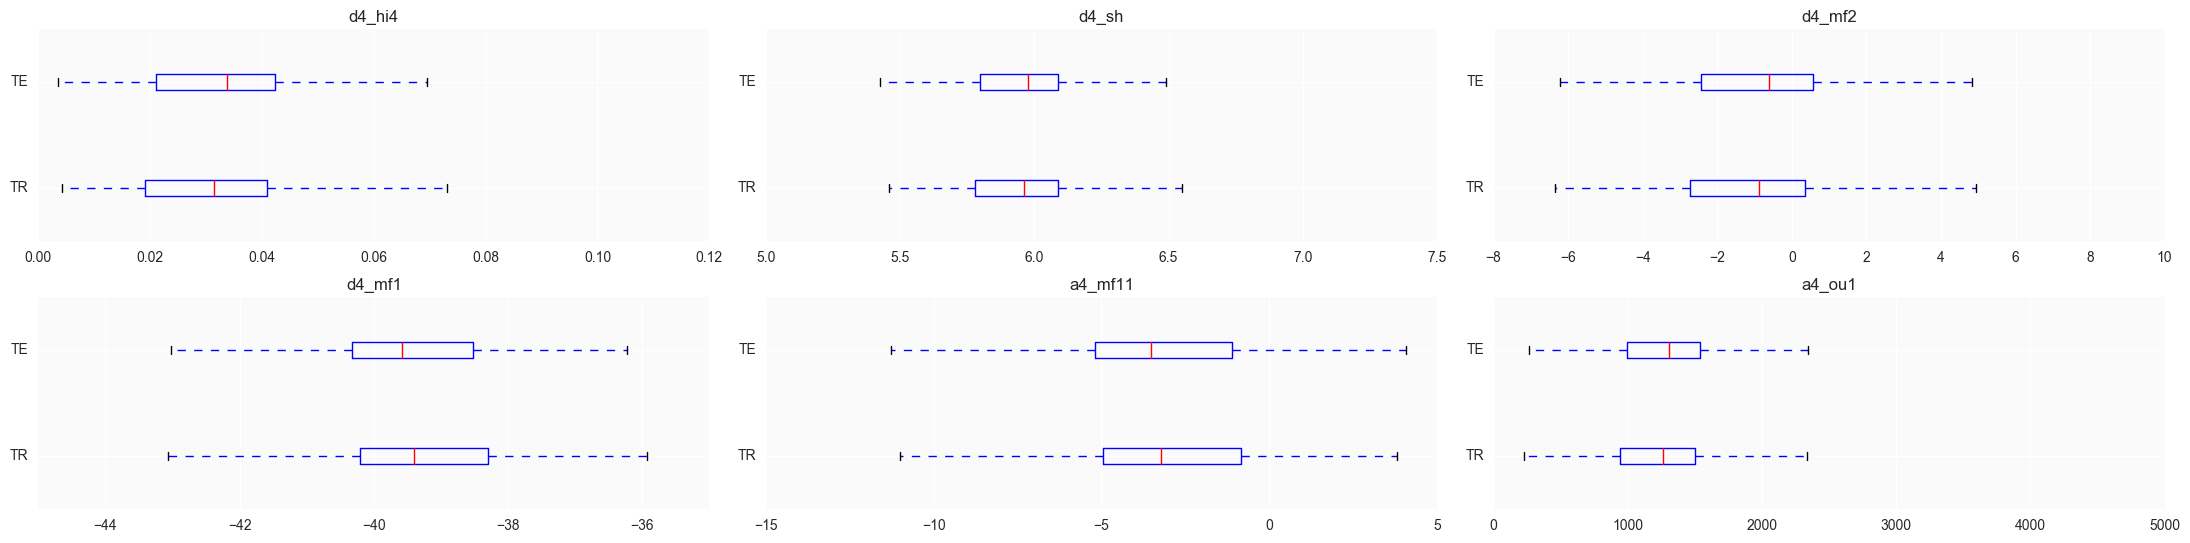

In [11]:
def plot_inputs_boxplots(X_tr, X_te, X_TE):
    total = X_tr.shape[0] + X_te.shape[0] + X_TE.shape[0]
    plt.figure(figsize=(22, 16))
    sns.despine(left=True)
    for i, col in enumerate(X_tr.columns):
        if i > 18:
            break
        data_to_plot = [pd.concat([X_tr[col], X_te[col]], ignore_index=True), X_TE[col]]
        ax1 = plt.subplot(6, 3, i + 1)
        ax1.boxplot(data_to_plot, vert=False)
        ax1.patch.set_facecolor('#FAFAFA')  
        plt.yticks([1, 2], ['TR', 'TE'])
        plt.title(col)
        
    plt.tight_layout()
    
plot_inputs_boxplots(X_tr0, X_te0, X_TE0)

In [ ]:
X_tr0.describe()

In [ ]:
X_TE0.describe()

In [ ]:
X_te0.describe()

Ideally, input training data should clearly show 17 subsequent earthquakes if plotted in the order they are present in the original dataset. It is OK to have a reasonable number of outliers in the training inputs provided that these anomalies are not occuring totally at random, but rather are somewhat close to the earthquakes in time. 

Vertical red line in these plots separates training+test samples from TEST samples. Unlike training+test, TEST data is not sequential, i.e. we dont't have time information for these samples. To add some structure to this data we order TEST with respect to the first (0th) input. 

Horizontal lines show medians for training+test (white) and for TEST (yellow). Ideally, they should be one line. 

In [ ]:
def plot_inputs_vs_time(X_tr, X_te, X_TE):
    total = X_tr.shape[0] + X_te.shape[0] + X_TE.shape[0]
    X_TE_sorted = X_TE.sort_values(X_TE.columns[0])
        
    plt.figure(figsize=(22, 16))
    for i, col in enumerate(X_tr.columns):
        ax1 = plt.subplot(6, 3, i + 1)
        ax1.scatter(range(total), pd.concat([X_tr[col], X_te[col], X_TE_sorted[col]], ignore_index=True))
        ax1.set_xlim([0, total])
        ax1.axvline(x=X_tr.shape[0], color='m')
        ax1.axvline(x=X_tr.shape[0]+X_te.shape[0], color='r')
        ax1.axhline(y=X_tr[col].median(), color='w')       
        ax1.axhline(y=X_te[col].median(), color='y')  
        ax1.patch.set_facecolor('#FAFAFA') 
        plt.title(col)
        
if True:
        plot_inputs_vs_time(X_tr=X_tr0, X_te=X_te0, X_TE=X_TE0)

Let's look at some scatter plots of our inputs (3 plots per input). We are comparing training+test (blue) and TEST (red) distributions. We see that red dots (TEST) overlap only with a portion of blue (training+test) cloud. 

In [ ]:
def plot_inputs_vs_inputs(X_tr, X_te, X_TE, fold_n=-1):
    total = X_tr.shape[0] + X_te.shape[0] + X_TE.shape[0]
    
    if fold_n < 0:
        print(pd.concat([X_TE.median(), X_tr.median(), (100*(X_TE.median() - X_tr.median())/X_TE.median()).astype(int)], axis=1))
    else:
        print('Fold =', fold_n)
        i1_tr = X_tr0_folds.iloc[fold_n][1].astype(int)
        i2_tr = X_tr0_folds.iloc[fold_n][2].astype(int)
        print(i1_tr)
        print(i2_tr)
        X_tr_fold = X_tr.iloc[range(i1_tr,i2_tr+1)]
        
        if fold_n < X_te0_folds.shape[0]:
            i1_te = X_te0_folds.iloc[fold_n][1].astype(int)
            i2_te = X_te0_folds.iloc[fold_n][2].astype(int)
            print(i1_te)
            print(i2_te)
            X_te_fold = X_te.iloc[range(i1_te,i2_te+1)]
        else: # show all test data if it is not pre-split into folds
            X_te_fold = X_te
            
        print(pd.concat([X_TE0.median(), X_tr_fold.median(), (100*(X_TE.median() - X_tr_fold.median())/X_TE.median()).astype(int)], axis=1))
        
    plt.figure(figsize=(22, 16))
    
    cnt = 0
    for i, coli in enumerate(X_tr.columns):
        for j, colj in enumerate(X_tr.columns):
            if j > 2:
                break
            if j == i:
                continue
            cnt = cnt + 1  
            ax1 = plt.subplot(X_tr0.shape[1], 3, cnt)
            if fold_n < 0: # plot all data, i.e. all folds
                ax1.scatter(pd.concat([X_tr[coli], X_te[coli]], ignore_index=True),
                            pd.concat([X_tr[colj], X_te[colj]], ignore_index=True), color='#8da0cb')
            else: # plot one fold
                ax1.scatter(pd.concat([X_tr_fold[coli], X_te_fold[coli]], ignore_index=True),
                            pd.concat([X_tr_fold[colj], X_te_fold[colj]], ignore_index=True), color='#8da0cb')                
            ax1.scatter(X_TE[coli], X_TE[colj], color='#fc8d62')
            ax1.patch.set_facecolor('#FAFAFA') 
            plt.title(colj) 
if bPlot:
        plot_inputs_vs_inputs(X_tr=X_tr0, X_te=X_te0, X_TE=X_TE0, fold_n=-1)

We can plot each training+test fold (0...15) separately (blue) and compare it with test data (red). Fold 6 and TEST match perfectly.

In [ ]:
if bPlot:
    plot_inputs_vs_inputs(X_tr=X_tr0, X_te=X_te0, X_TE=X_TE0, fold_n=6)

We might remove some earthquakes from our training data and keep only data that match test samples in terms of median values (less than 10% difference). Alternatively, we can keep only those training samples that share k-means clusters with TEST samples. 

My list:
folds_used = [0, 1, 3, 5, 6, 8, 9, 13] (short earthquakes)  
folds_used = [1, 2, 3, 4, 7, 9, 10, 11, 12, 13, 14, 15] (close to TEST)

Winner:
folds_used = [0, 1, 2, 4, 7, 9, 10, 11, 13, 14] 

In [40]:
def create_fold_mask(X, y, X_folds, X_TE, folds_used_init, Tthr=-1, bDthr=False):
    
    print("=========================================")
    print(X.shape)
    
    Tmax_TE = 10 #X_folds.loc[1:,"Tmax"].median() 
    Tnext_TE = Tmax_TE
    if Tthr > 0:
        print("Will be using only samples with time > Tmax *"+str(Tthr))
    
    F = pd.DataFrame(np.zeros(X.shape[0])).astype('int') #int: fold ID
    F.columns = ['foldID']
    Tmax = pd.DataFrame(np.zeros(X.shape[0])).astype('float') # float: fold Tmax
    Tmax.columns = ['Tmax']
    Tnext = pd.DataFrame(np.zeros(X.shape[0])).astype('float') # float: fold Tnext
    Tnext.columns = ['Tnext']
    
    # boolean mask: use the whole fold for training?
    bU = np.zeros(X.shape[0]).astype(bool)
    
    # boolean mask: is sample near TEST samples?
    bN = np.zeros(X.shape[0]).astype(bool) 
    bN = True

    m = X_TE.median()
    p = X_TE.quantile([0.25, 0.5, 0.75])
    
    if bDthr:
        folds_used = list()
    else:
        folds_used = folds_used_init  
    df_delta = pd.DataFrame()
        
    for fold_n in folds_used_init:
        if fold_n >= X_folds.shape[0]:
            break
            
        i1 = X_folds.iloc[fold_n][1].astype(int)
        i2 = X_folds.iloc[fold_n][2].astype(int)
        ind = range(i1,i2+1)
        
        F.iloc[ ind ] = fold_n
        tmax = X_folds.iloc[fold_n][3]
        Tmax.iloc[ ind ] = tmax
        Tnext.iloc[ ind ] = X_folds.iloc[fold_n][4]
        
        bU[ ind ] = (fold_n in folds_used)
        if Tthr > 0:
            bU[ ind ] = (y.iloc[ ind ] > Tthr * tmax).values.flatten()
            
        # TODO: compute fold median only for bU[ ind ] == True     
        delta = (100*(m - X.iloc[ ind ].median())/m).abs().astype(int)
        if fold_n == 0:
            df_delta = delta
        else: 
            df_delta = pd.concat([df_delta, delta], axis=1)  
        
    if bDthr:
        #df_delta.columns = [str(x) for x in range(df_delta.shape[1])]
        if not df_delta.empty:
            print("Difference 100% * (median(tr)-median(TE))/median(TE) for all folds")
            print(df_delta)

        d75 = df_delta.quantile([0.75],axis=1)
        for fold_n in folds_used_init:
            if fold_n >= X_folds.shape[0]:
                break

            i1 = X_folds.iloc[fold_n][1].astype(int)
            i2 = X_folds.iloc[fold_n][2].astype(int)
            ind = range(i1,i2+1)

            # Decide if this folder is used for training
            b = (df_delta.iloc[:,fold_n] <= d75).values.sum() == X.shape[1]           
            bU[ ind ] = b
            if b:
                print("Will be using fold=",fold_n)
                folds_used.append(fold_n)   
            else:
                print("Will skip fold=",fold_n)
                print(df_delta.iloc[:,fold_n] <= d75)

            
    # Estimate how far the sample is from TEST
    # Check 1st quartile and 3rd quartile, find outliers
    iqr = (p.iloc[2,:] - p.iloc[0,:]) * 1.5 
    for i, col in enumerate(X.columns):
        bN = bN & (X[col] >= p.iloc[0,i]-iqr.iloc[i]) & (X[col] <= p.iloc[2,i]+iqr.iloc[i])            
            
    print("Will be using ", sum(bU), " out of ", len(bU), " samples")
    print("Found ", sum((bN & bU)), " out of ", sum(bU), " samples near TEST")
    
    df_bU = pd.DataFrame({'use': bU})
    print(df_bU.shape)
    
    return df_bU, bN, F, Tmax, Tnext, folds_used, Tmax_TE, Tnext_TE

bU_tr0, bN_tr0, F_tr0, Tmax_tr0, Tnext_tr0, folds_used, Tmax_TE, Tnext_TE = create_fold_mask(X_tr0, y_tr0, X_tr0_folds, X_TE0, 
                                                                                             range(0,17),Tthr=-0.028,bDthr=False) #[3, 5, 6, 8, 9, 12, 13, 15]
bU_te0, bN_te0, F_te0, Tmax_te0, Tnext_te0, folds_used, Tmax_TE, Tnext_TE = create_fold_mask(X_te0, y_te0, X_te0_folds, X_TE0, 
                                                                                             range(0,17), Tthr=-0.028,bDthr=False)
#bU_te0, bN_te0, F_te0, Tmax_te0, Tnext_te0, folds_used, Tmax_TE, TnextTE = create_fold_mask(X_te0, y_te0, X_te0_folds, X_TE0, folds_used, Tthr=-Tthr,bDthr=False)
print("Tmax_TE=",Tmax_TE)
print("Tnext_TE=",Tnext_TE)

(195228, 6)
Will be using  195228  out of  195228  samples
Found  193590  out of  195228  samples near TEST
(195228, 1)
(4194, 6)
Will be using  4194  out of  4194  samples
Found  4152  out of  4194  samples near TEST
(4194, 1)
Tmax_TE= 10
Tnext_TE= 10


In [ ]:
bU_tr0.shape

Let's rearrange our data so that X_tr_pruned contained only our selected folders. 

All other folders go to X_te_pruned and will be used for internal testing. It is already clear that our model will extrapolate on these test samples, so we don't expect good MAE there, but the model should adequately reproduce the trend at least for those test points that have all inputs within 3 sigmas from training medians. For predicting model's performance on TEST we are mostly interested in test points within 3 sigmas from TEST medians.

We already have a mask for our training samples, so we just use it to rearrange the data

In [41]:
def prune_data(bU0, X0, y0, F0, Tmax0, Tnext0, bN0):
    mask = bU0.astype(bool)
    
    X = X0.iloc[ mask,: ].reset_index(drop=True)
    y = y0.iloc[ mask,: ].reset_index(drop=True)
    F = F0.iloc[ mask,: ].reset_index(drop=True)  
    Tmax = Tmax0.iloc[ mask,: ].reset_index(drop=True)  
    Tnext = Tnext0.iloc[ mask,: ].reset_index(drop=True)  
    bN = bN0[ mask ]
    
    print(X.shape)
    print(y.shape)
    print(F.shape)
    print(bN.shape)
    return X, y, F, Tmax, Tnext, bN

X_tr_pruned, y_tr, F_tr, Tmax_tr, Tnext_tr, bN_tr = prune_data(bU_tr0.values.flatten(), X_tr0, y_tr0, F_tr0, Tmax_tr0, Tnext_tr0, bN_tr0)
X_te_pruned, y_te, F_te, Tmax_te, Tnext_te, bN_te = prune_data(bU_te0.values.flatten(), X_te0, y_te0, F_te0, Tmax_te0, Tnext_te0, bN_te0)

(195228, 6)
(195228, 1)
(195228, 1)
(195228,)
(4194, 6)
(4194, 1)
(4194, 1)
(4194,)


Now that I've chosen the folds I will define scaling parameter on our pruned training data and then use this scaling for all 3 datasets 

In [42]:
bScale = True
if bScale:
    scaler = StandardScaler() # scales to mean=0, std=1
    scaler.fit(X_tr_pruned)
    
    X_tr = pd.DataFrame(scaler.transform(X_tr_pruned), columns=X_tr_pruned.columns)
    X_te = pd.DataFrame(scaler.transform(X_te_pruned), columns=X_te_pruned.columns)
    X_TE = pd.DataFrame(scaler.transform(X_TE0), columns=X_TE0.columns)
else:
    X_tr = X_tr_pruned
    X_te = X_te_pruned
    X_TE = X_TE0
X_tr.head()

,d4_hi4,d4_sh,d4_mf2,d4_mf1,a4_mf11,a4_ou1
0,0.251222090085342,0.339912957756685,0.254566779963108,-0.475672372544040,-0.581384307454863,0.405251155661998
1,0.320708463359980,0.338471990835359,0.752371427051463,0.364617912749370,-0.697162714400747,0.282452404282267
2,0.170154654598265,0.300129411185296,0.218539806185024,-0.470552918470615,-0.621465539912142,0.484709171260647
3,0.108388989465253,0.312831688331366,0.656411430679940,0.013942551663062,-0.665397697853700,0.282452404282267
4,0.185596070881518,0.271568174170055,0.573585960482234,-0.145366572511659,-0.644251272093075,0.275228948318753


Vertical magenta line separates training and test points in these plots.

In [ ]:
if bPlot:
    plot_inputs_vs_time(X_tr=X_tr, X_te=X_te, X_TE=X_TE)

Use KNN to choose training data points

In [43]:
from sklearn.neighbors import NearestNeighbors

if True:
    # Get nearest taining neighbors for TEST
    neigh = NearestNeighbors(n_neighbors=5)
    neigh.fit(X_tr.values) 
    #N_TE = neigh.kneighbors(X_TE.values, return_distance=False) 
    N_TE = neigh.kneighbors(X_TE.values) 

    # Distances
    print(np.min(N_TE[0].flatten()))
    print(np.median(N_TE[0].flatten()))
    print(np.max(N_TE[0].flatten()))

    # Indices
    if bPlot:
        plot_TIME_vs_time(N_TE[0].flatten(), "Distances to nearest training neighbors for TEST")
        
    # Prepare bU_tr
    bU_tr = np.zeros(len(X_tr))
    bU_tr[ N_TE[1].flatten() ] = True
    bU_tr0[ bU_tr0.values.flatten() ] = bU_tr
    bU_tr0.astype(int).to_csv(sModel+"_u_tr.csv", index=False)

    # Get nearest test neighbors for TEST
    neigh = NearestNeighbors(n_neighbors=1)
    neigh.fit(X_te.values) 
    N_TE = neigh.kneighbors(X_TE.values) 
    bU_te = np.zeros(len(X_te))
    bU_te[ N_TE[1].flatten() ] = True
    bU_te0[ bU_te0.values.flatten() ] = bU_te
    bU_te0.astype(int).to_csv(sModel+"_u_te.csv", index=False)

    X_tr, y_tr, F_tr, Tmax_tr, Tnext_tr, bN_tr = prune_data(bU_tr, X_tr, y_tr, F_tr, Tmax_tr, Tnext_tr, bN_tr)
    X_te, y_te, F_te, Tmax_te, Tnext_te, bN_te = prune_data(bU_te, X_te, y_te, F_te, Tmax_te, Tnext_te, bN_te)

0.022623452014282952
0.12895533773166543
0.9682449003444997
(12573, 6)
(12573, 1)
(12573, 1)
(12573,)
(1809, 6)
(1809, 1)
(1809, 1)
(1809,)


In [44]:
EPS = np.finfo(float).eps * 10

def encode(y, Tmax, Tnext):
    print("Encoding to [0,1]...", str(y.shape))        
    if np.isscalar(Tmax):
        y = y * (1./Tmax)
    else:
        y = np.divide(y.flatten(), Tmax.flatten())
    return y.flatten()

def decode(y, Tmax, Tnext):
    print("Decoding from [0,1]...", str(y.shape))
    if np.isscalar(Tmax):
        y = y * Tmax
    else:
        y = np.multiply(y.flatten(), Tmax.flatten())
    return y.flatten()

if False:
    xx = np.array([0.05,0.066,0.1,0.5,1,1.5,1.934,2.0])                
    print(xx)
    tmax = np.array([2,2,2,2,2,2,2,2])
    tnext = np.array([2.5,2.5,2.5,2.5,2.5,2.5,2.5,2.5])
    yy = encode(xx,tmax,tnext)
    print(yy)
    tt = decode(yy,tmax,tnext)
    print(tt)

In [45]:
bEncode = False

def save_importances(feature_importance, fold_n, imp, feature_names):
    fold_importance = pd.DataFrame()
    fold_importance["feature"] = feature_names
    fold_importance["importance"] = imp
    fold_importance["fold"] = fold_n + 1
    feature_importance = pd.concat([feature_importance, fold_importance], axis=0)
    return feature_importance  
    
def train_model(X_tr=X_tr, X_te=X_te, X_TE=X_TE, y_tr=y_tr, y_te=y_te, F_tr=F_tr, 
                Tmax_tr=Tmax_tr, Tmax_te=Tmax_te, Tmax_TE=Tmax_TE,
                Tnext_tr=Tnext_tr, Tnext_te=Tnext_te, Tnext_TE=Tnext_TE, 
                model_type='xgb', params=None, folds_used=folds_used,  
                plot_feature_importance=False, feature_names=X_tr.columns, 
                sModel=sModel, sExperiment='', model_types=model_types_train):

    z_va = np.zeros(len(X_tr))
    z_te = np.zeros(len(X_te))
    z_TE = np.zeros(len(X_TE))
    feature_importance = pd.DataFrame()
    n_fold = 1
    scores_va = []
    n_iter = min(len(y_tr),20000)
        
    if model_type not in model_types:
        print(model_type+' is not in the list. Skipping.')
        if (model_type == 'xgb') | (model_type == 'lgb'):    
            feature_importance = save_importances(feature_importance, 1, np.zeros(len(feature_names)), feature_names)
            return z_va, z_te, z_TE, feature_importance
        return z_va, z_te, z_TE
    
    # 17-fold cross-validation: train 17 models using 17 earthquakes of training data for validation and early stopping 
    n_fold = len(folds_used)
    file = open(sModel+'_e_va_'+model_type+sExperiment+'.csv','w+') 
    file.write("fold,MAE\n")
    file.close() 

    fold_num = 0
    for fold_n in folds_used: #range(n_fold):

        print('^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^')
        print('')
        print('Fold', fold_n, 'started at', time.ctime())

        valid_mask = (F_tr == fold_n).values.reshape(-1,) # numpy.ndarray
        train_mask = (F_tr != fold_n).values.reshape(-1,) # numpy.ndarray
        if sum(train_mask) == X_tr.shape[0]:
            print("No validation data for this fold. Skipping")
            continue
        else:
            print(sum(train_mask))
        fold_num = fold_num+1
            
        X_train, X_valid = X_tr[train_mask], X_tr[valid_mask] # pandas.core.frame.DataFrame
        y_train, y_valid = y_tr[train_mask], y_tr[valid_mask] # pandas.core.frame.DataFrame

        if bEncode:
            # Encode y_train
            Tmax_train, Tmax_valid = Tmax_tr[train_mask], Tmax_tr[valid_mask]                
            Tnext_train, Tnext_valid = Tnext_tr[train_mask], Tnext_tr[valid_mask]                
            y_train = pd.DataFrame(encode(y_train.values, Tmax_train.values, Tnext_train.values)) # pandas.core.frame.DataFrame
            y_valid = pd.DataFrame(encode(y_valid.values, Tmax_valid.values, Tnext_valid.values)) # pandas.core.frame.DataFrame

        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=feature_names)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=feature_names)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=n_iter, evals=watchlist, 
                early_stopping_rounds=200, verbose_eval=500, params=params)

            z_valid = model.predict(xgb.DMatrix(X_valid, feature_names=feature_names), ntree_limit=model.best_ntree_limit).reshape(-1,)
            z_test = model.predict(xgb.DMatrix(X_te, feature_names=feature_names), ntree_limit=model.best_ntree_limit).reshape(-1,)
            z_TEST = model.predict(xgb.DMatrix(X_TE, feature_names=feature_names), ntree_limit=model.best_ntree_limit).reshape(-1,)

            imp = list(model.get_score(importance_type='gain').values())
            feature_importance = save_importances(feature_importance, fold_n, imp, feature_names)

        if model_type == 'lgb':
            model = lgb.LGBMRegressor(**params, n_estimators = n_iter, nthread = 4, n_jobs = -1)
            model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_valid, y_valid)], 
                eval_metric='mae', verbose=10000, early_stopping_rounds=200)

            z_valid = model.predict(X_valid, num_iteration=model.best_iteration_).reshape(-1,)
            z_test = model.predict(X_te, num_iteration=model.best_iteration_).reshape(-1,)
            z_TEST = model.predict(X_TE, num_iteration=model.best_iteration_).reshape(-1,)

            feature_importance = save_importances(feature_importance, fold_n, model.feature_importances_, feature_names)

        if model_type == 'rcv':
            model = RidgeCV(alphas=(0.01, 0.1, 1.0, 10.0, 100.0), scoring='neg_mean_absolute_error', cv=3)
            model.fit(X_train, y_train)

            z_valid = model.predict(X_valid).reshape(-1,)
            z_test = model.predict(X_te).reshape(-1,)
            z_TEST = model.predict(X_TE).reshape(-1,)

        if model_type == 'svr':
            model = NuSVR(gamma='scale', nu=0.9, C=10)
            model.get_params(deep=True)
            model.fit(X_train, y_train)

            z_valid = model.predict(X_valid).reshape(-1,)
            z_test = model.predict(X_te).reshape(-1,)
            z_TEST = model.predict(X_TE).reshape(-1,)

        if model_type == 'lr':
            model = LinearRegression()
            model.fit(X_train, y_train)

            z_valid = model.predict(X_valid.values).reshape(-1,) # numpy.ndarray
            z_test = model.predict(X_te.values).reshape(-1,) # numpy.ndarray
            z_TEST = model.predict(X_TE.values).reshape(-1,) # numpy.ndarray
            
        if model_type == 'ff':
            model = MLPRegressor(hidden_layer_sizes=(15,15,15,),
                                 activation='relu',
                                 solver='adam',
                                 #solver='lbfgs',
                                 learning_rate='adaptive',
                                 max_iter=n_iter*10, 
                                 verbose=True,
                                 learning_rate_init=0.01,
                                 alpha=0.01)
            model.fit(X_train, y_train)

            z_valid = model.predict(X_valid.values).reshape(-1,) # numpy.ndarray
            z_test = model.predict(X_te.values).reshape(-1,) # numpy.ndarray
            z_TEST = model.predict(X_TE.values).reshape(-1,) # numpy.ndarray
            
        if model_type == 'knn':
            model = KNeighborsRegressor(n_neighbors=params)
            
            model.fit(X_train.values, y_train.values)
            z_valid = model.predict(X_valid.values).reshape(-1,) # numpy.ndarray
            z_test = model.predict(X_te.values).reshape(-1,) # numpy.ndarray
            z_TEST = model.predict(X_TE.values).reshape(-1,) # numpy.ndarray
            
        # Replace all negative predictions with zeros
        z_valid[z_valid < 0] = 0
        z_test[z_test < 0] = 0
        z_TEST[z_TEST < 0] = 0

        if bEncode:
            # Decode z_valid, z_te, z_TE
            y_valid = y_tr[valid_mask]
            #z_valid = decode(z_valid, Tmax_valid['Tmax'].values, Tnext_valid['Tnext'].values)
            #z_test = decode(z_test, Tmax_te['Tmax'].values, Tnext_te['Tnext'].values)
            z_valid = decode(z_valid, Tmax_TE, Tnext_TE)
            z_test = decode(z_test, Tmax_TE, Tnext_TE)
            z_TEST = decode(z_TEST, Tmax_TE, Tnext_TE)
       
        score_valid = mean_absolute_error(y_valid, z_valid)
        scores_va.append(score_valid)
        print("%s %d %s %f" % ('Fold', fold_n, ' MAE:', score_valid))
        print('')

        file = open(sModel+'_e_va_'+model_type+sExperiment+'.csv','a+') 
        file.write(str(fold_n)+","+str(score_valid)+"\n")
        file.close() 

        z_va[valid_mask] = z_valid
        z_te += z_test 
        z_TE += z_TEST

        # Save model to disk. See also https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/
        #joblib.dump(model, sModel+'_'+model_type+'_'+str(fold_n)+'.bin')
        # To load the model from disk:
        #loaded_model = joblib.load(filename)

    z_te /= fold_num
    z_TE /= fold_num

    
    print('==================================')
    print('==================================')
    print('')
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores_va), np.std(scores_va)))
    
    score_z_va = mean_absolute_error(y_tr, z_va)
    score_z_te = mean_absolute_error(y_te, z_te)
    
    file = open(sModel+'_e_va_'+model_type+sExperiment+'.csv','a+') 
    file.write("CV"+","+str(score_z_va)+"\n")
    file.write("test"+","+str(score_z_te)+"\n")
    file.close()     
    
    if (model_type == 'lgb') | (model_type == 'xgb'):
        feature_importance["importance"] /= n_fold
        
        if plot_feature_importance:
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]
            
            plt.figure(figsize=(6, 6));
            f = best_features[0:len(feature_names)]
            sns.barplot(x="importance", y="feature", data=f.sort_values(by="importance", ascending=False))
            plt.title('Top 50 Features')
            
            feature_importance.to_csv(sModel+'_a_importance.csv')
        
        return z_va, z_te, z_TE, feature_importance    
    else:
        return z_va, z_te, z_TE

In [46]:
z_va_knn, z_te_knn, z_TE_knn = train_model(model_type='knn', params=5)

z_va_lr, z_te_lr, z_TE_lr = train_model(model_type='lr')

z_va_ff, z_te_ff, z_TE_ff = train_model(model_type='ff', params=None)

z_va_rcv, z_te_rcv, z_TE_rcv = train_model(model_type='rcv', params=None)

z_va_svr, z_te_svr, z_TE_svr = train_model(model_type='svr', params=None)

params_lgb = {'num_leaves': 54,
         'min_data_in_leaf': 79,
         'objective': 'regression_l1',
         'max_depth': 15,
         'learning_rate': 0.018545526395058548,
         "boosting": "gbdt",
         "feature_fraction": 0.8354507676881442,
         "bagging_freq": 3,
         "bagging_fraction": 0.8126672064208567,
         "bagging_seed": 11,
         "metric": 'mae',
         "lambda_l1": 0.1,
         "verbosity": -1,
         'min_child_weight': 5.343384366323818,
         'reg_alpha': 1.1302650970728192,
         'reg_lambda': 0.3603427518866501,
         'subsample': 0.8767547959893627,}
z_va_lgb, z_te_lgb, z_TE_lgb, feature_importance = train_model(model_type='lgb', params=params_lgb, plot_feature_importance=True)
#feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)

for depth in [5]: #[10,15,20]:
    for learning_rate in [0.01]: #[0.001, 0.01, 0.1, 0.2]:
        sExperiment="_depth"+str(depth)+"_eta"+str(learning_rate)
        params_xgb = {'max_depth': depth, 
                      'learning_rate': learning_rate, #eta': 0.01,
                      'subsample': 0.8, 
                      'colsample_bytree': 0.8, 
                      'objective': 'reg:linear', 
                      'eval_metric': 'mae', 
                      'silent': True, 
                      'nthread': 4}
        z_va_xgb, z_te_xgb, z_TE_xgb, feature_importance = train_model(model_type='xgb', params=params_xgb, sExperiment=sExperiment)
#feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(by="importance", ascending=False)

^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Fold 0 started at Tue Aug 27 16:16:39 2019
12507
Fold 0  MAE: 2.877202

^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Fold 1 started at Tue Aug 27 16:16:39 2019
11486
Fold 1  MAE: 1.615061

^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Fold 2 started at Tue Aug 27 16:16:39 2019
11896
Fold 2  MAE: 2.648780

^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Fold 3 started at Tue Aug 27 16:16:40 2019
12189
Fold 3  MAE: 1.839825

^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Fold 4 started at Tue Aug 27 16:16:40 2019
11938
Fold 4  MAE: 1.777478

^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Fold 5 started at Tue Aug 27 16:16:40 2019
12031
Fold 5  MAE: 3.007488

^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Fold 6 started at Tue Aug 27 16:16:40 2019
11969
Fold 6  MAE: 2.689137

^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Fold 7 started at Tue Aug 27 16:16:40 2019
10697
Fold 7  MAE: 3.414428

^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Fold 8 started at Tue Aug 27 16:16:41 2019
12116
Fold 8  MAE: 3.193780

^^^^^^^^^^^^^^^^^^^^^^^^^^^^

In [32]:
if False:
    z_va_ff = decode(z_va_ff, Tmax_tr['Tmax'].values * 0.1, 1)
    z_te_ff = decode(z_te_ff, Tmax_te['Tmax'].values * 0.1, 1)

Decoding from [0,1]... (10000,)
Decoding from [0,1]... (4194,)


In [47]:
model_types_final=['ff']

def blend_models(z_knn=z_te_knn, z_lr=z_te_lr, z_ff=z_te_ff, z_rcv=z_te_rcv, z_svr=z_te_svr, z_lgb=z_te_lgb, z_xgb=z_te_xgb, model_types=model_types_final):
    #print('Blending ', len(model_types), ' model(s): ', model_types)
    prediction = np.zeros(len(z_xgb))
    if 'knn' in model_types:
        prediction += z_knn;
    if 'lr' in model_types:
        prediction += z_lr;
    if 'ff' in model_types:
        prediction += z_ff;
    if 'rcv' in model_types:
        prediction += z_rcv;
    if 'svr' in model_types:
        prediction += z_svr;
    if 'lgb' in model_types:
        prediction += z_lgb;
    if 'xgb' in model_types:
        prediction += z_xgb;
    prediction /= len(model_types)
    return prediction

z_va = blend_models(z_knn=z_va_knn, z_lr=z_va_lr, z_ff=z_va_ff, z_rcv=z_va_rcv, z_svr=z_va_svr, z_lgb=z_va_lgb, z_xgb=z_va_xgb)
score_z_va = mean_absolute_error(y_tr, z_va)
print("%s %f" % ('Validation MAE:', score_z_va))
file = open(sModel+'_e_va.csv','wt') 
file.write(str(score_z_va)) 
file.close() 

z_te = blend_models(z_knn=z_te_knn, z_lr=z_te_lr, z_ff=z_te_ff, z_rcv=z_te_rcv, z_svr=z_te_svr, z_lgb=z_te_lgb, z_xgb=z_te_xgb)
score_te = mean_absolute_error(y_te, z_te)
print("%s %f" % ('Test MAE:', score_te))
file = open(sModel+'_e_te.csv','wt') 
file.write(str(score_te)) 
file.close() 
    
z_TE = blend_models(z_knn=z_TE_knn, z_lr=z_TE_lr, z_ff=z_TE_ff, z_rcv=z_TE_rcv, z_svr=z_TE_svr, z_lgb=z_TE_lgb, z_xgb=z_TE_xgb)
z_TE_df = pd.read_csv('sample_submission.csv')
z_TE_df["time_to_failure"] = z_TE
z_TE_df.to_csv(sModel+'_z_TEST.csv', index=False)

Validation MAE: 2.240494
Test MAE: 2.011070


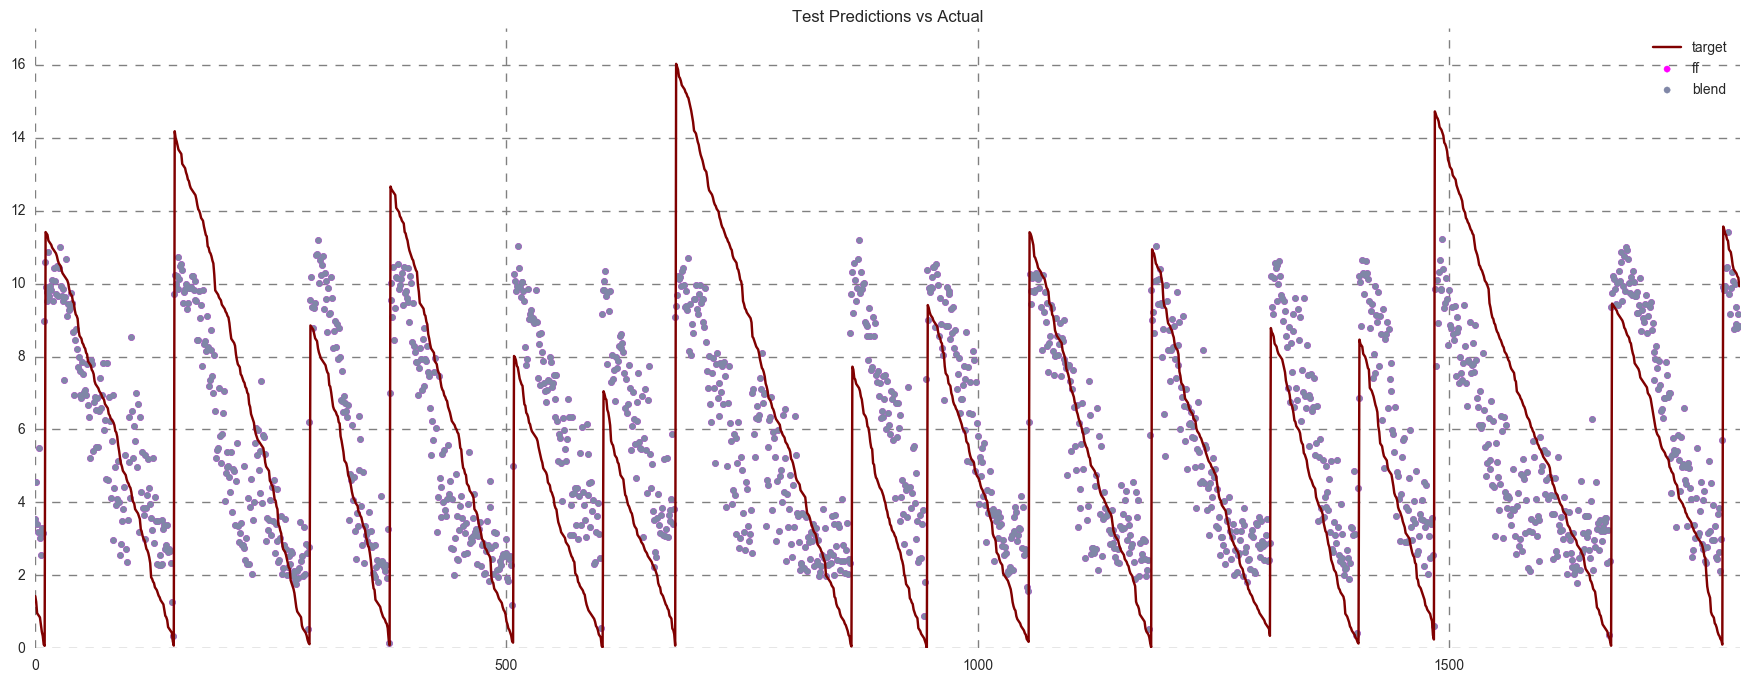

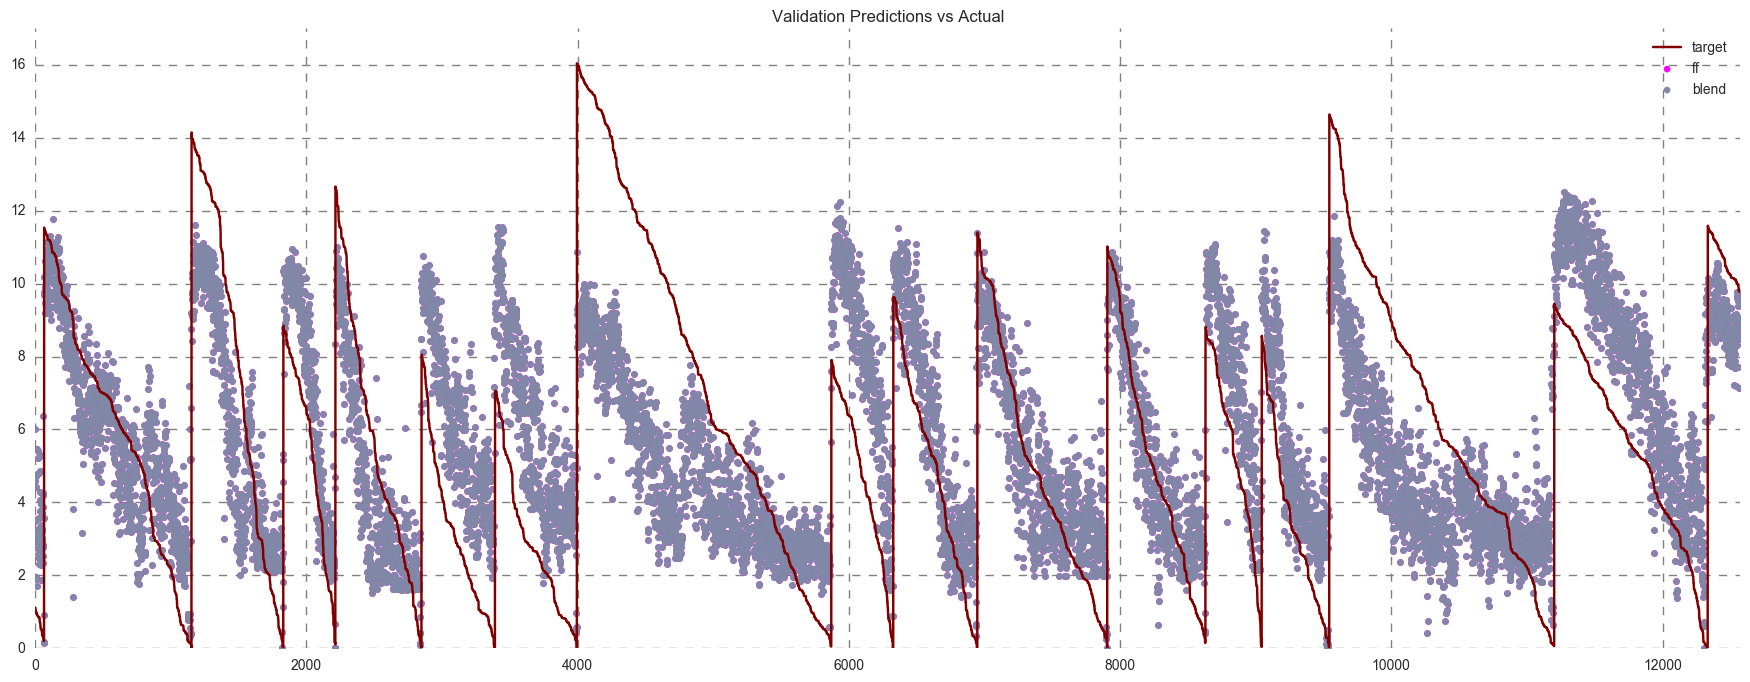

In [48]:
def plot_models(z_knn=z_va_knn, z_lr=z_va_lr, z_ff=z_va_ff, z_rcv=z_va_rcv, z_svr=z_va_svr, z_lgb=z_va_lgb, z_xgb=z_va_xgb, 
                y=y_tr, z=z_va, model_types=model_types_final, stitle="Predictions vs Actual"):    
    x = range(len(z))
    fig1 = plt.figure(figsize=(22, 8))
    ax1 = plt.subplot(1,1,1)
    if 'ff' in model_types:
        ax1.scatter(x,z_ff,  color='magenta'   , label='ff')
    if False:
        if 'knn' in model_types:
            ax1.scatter(x,z_knn,  color='green'   , label='knn')
        if 'lr' in model_types:
            ax1.scatter(x,z_lr,  color='red'   , label='lr')
        if 'rcv' in model_types:
            ax1.scatter(x,z_rcv, color='blue', label='rcv')
        if 'svr' in model_types:
            ax1.scatter(x,z_svr, color='#FAE3AD', label='svr')
        if 'lgb' in model_types:
            ax1.scatter(x,z_lgb, color='#7096A0', label='lgb')
        if 'xgb' in model_types:  
            ax1.scatter(x,z_xgb, color='#F25059', label='xgb')        
    ax1.scatter(x,z,color='#8087A7', label='blend')
    
    ax1.plot(x,y,color='#800000', label='target')
    
    ax1.patch.set_facecolor('white') # works with plt.show()
    ax1.set_xlim([0, len(z)])
    ax1.set_ylim([0, int(max(y.values)+1)])
    ax1.grid(b=True, which='major', color='grey', linestyle='--')
    ax1.legend()
    plt.title(stitle)
    fig1.savefig('c:/Users/nely_/A_Projects/Python/ShakingEarth/docs/plots/'+stitle+'.png')
        

plot_models(z_knn=z_te_knn, z_lr=z_te_lr, z_ff=z_te_ff, z_rcv=z_te_rcv, z_svr=z_te_svr, z_lgb=z_te_lgb, z_xgb=z_te_xgb, 
            y=y_te, z=z_te, model_types=model_types_train, stitle="Test Predictions vs Actual")

plot_models(z_knn=z_va_knn, z_lr=z_va_lr, z_ff=z_va_ff, z_rcv=z_va_rcv, z_svr=z_va_svr, z_lgb=z_va_lgb, z_xgb=z_va_xgb, 
            y=y_tr, z=z_va, model_types=model_types_train, stitle="Validation Predictions vs Actual")

if bPlot:
    plot_models(z_knn=z_te_knn[bN_te], z_lr=z_te_lr[bN_te],  z_ff=z_te_ff[bN_te], z_rcv=z_te_rcv[bN_te], z_svr=z_te_svr[bN_te], z_lgb=z_te_lgb[bN_te], z_xgb=z_te_xgb[bN_te], 
            y=y_te[bN_te], z=z_te[bN_te], stitle="Test near TEST Predictions vs Actual"); 